## Import Libraries

In [58]:
import numpy as np
from astropy.io import ascii
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
from astropy.table import Table, Column
from scipy.stats import norm
import emcee
import batman

# HAT-P-20b Transit  (Observed Data from the 61")

In [3]:
# Import HAT-P-20b_Measurements.txt file and extract the light curve data.
data = ascii.read('HAT-P-20b_Measurements.txt')

In [4]:
# Extract Time, Flux and Error in Flux
time = data['JD_UTC']
rel_flux_T1_dn = data['rel_flux_T1_dn']
rel_flux_err_T1_dn = data['rel_flux_err_T1_dn']*3.124543156214643

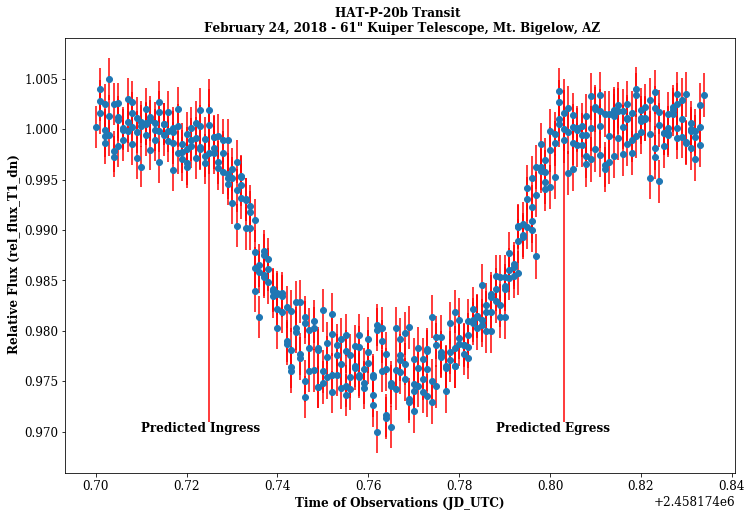

In [5]:
# Plot Light Curve.
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(time, rel_flux_T1_dn, yerr=rel_flux_err_T1_dn, xerr=None, fmt='o', ecolor='r', elinewidth=None, capsize=None, barsabove=False)
x1 = 2458174.725
x2 = 2458174.803
ax.vlines(x1, ymin=0.971, ymax= 1.005, color='r')
ax.vlines(x2, ymin=0.971, ymax= 1.005, color='r')
plt.text(2458174.710, 0.970, 'Predicted Ingress', fontsize='large', fontweight='bold')
plt.text(2458174.788, 0.970, 'Predicted Egress', fontsize='large', fontweight='bold')
ax.set_xlabel('Time of Observations (JD_UTC)', fontsize='large', fontweight='bold')
ax.set_ylabel(' Relative Flux (rel_flux_T1_dn)', fontsize='large', fontweight='bold')
ax.set_title('HAT-P-20b Transit \n February 24, 2018 - 61" Kuiper Telescope, Mt. Bigelow, AZ', fontsize='large', fontweight='bold')
#plt.savefig('initial_lightcurve_HATP20b.png', overwrite = True)
plt.show()

# HAT-P-20b MCMC with BATMAN

In [6]:
# Initial Parameters for the Transit
pars = np.zeros(4)
pars[0] = 2455080.92661   # Transit Center Time (t_0)
pars[1] = 86.80           # Orbital Inclination (in degrees)                  
pars[2] = 0.1284          # Planet Radius (in units of stellar radii)                    
pars[3] = 11.23           # Semimajor Axis [a/rstar](in units of stellar radii)

In [7]:
pars

array([2.45508093e+06, 8.68000000e+01, 1.28400000e-01, 1.12300000e+01])

In [8]:
# Define Transit Model Function
def transitmodel(pars, time):
    params = batman.TransitParams()
    params.t0 = pars[0]
    params.inc = pars[1]
    params.rp = pars[2]
    params.a = pars[3]
    params.per = 2.8753170 
    params.ecc = 0.0150                  # Eccentricity
    params.w = 90                        # Longitude of Periastron (in degrees)                 
    params.limb_dark = "quadratic"       # Limb Darkening Model   
    params.u = [0.77822530, 0.019420697] # Limb Darkening Coefficients
    transitmod = batman.TransitModel(params, time)
    lc = transitmod.light_curve(params)
    return lc

In [29]:
rel_flux = transitmodel(pars,time)

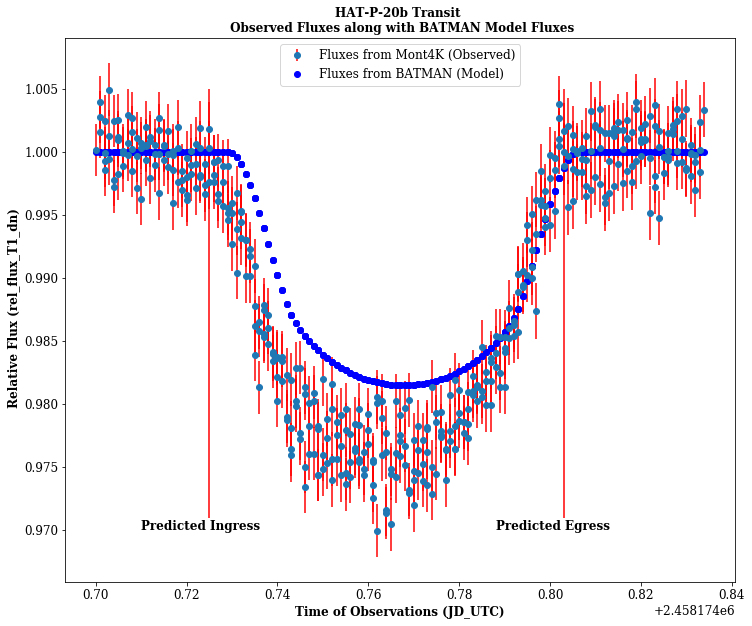

In [10]:
# Plot Light Curve with BATMAN Model
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (12,10))
mont4k = ax.errorbar(time, rel_flux_T1_dn, yerr=rel_flux_err_T1_dn, xerr=None, fmt='o', ecolor='r', elinewidth=None, capsize=None, barsabove=False)
model = ax.plot(time, rel_flux, 'bo')
x1 = 2458174.725
x2 = 2458174.803
ax.vlines(x1, ymin=0.971, ymax= 1.005, color='r')
ax.vlines(x2, ymin=0.971, ymax= 1.005, color='r')
plt.text(2458174.710, 0.970, 'Predicted Ingress', fontsize='large', fontweight='bold')
plt.text(2458174.788, 0.970, 'Predicted Egress', fontsize='large', fontweight='bold')
ax.set_xlabel('Time of Observations (JD_UTC)', fontsize='large', fontweight='bold')
ax.set_ylabel(' Relative Flux (rel_flux_T1_dn)', fontsize='large', fontweight='bold')
ax.set_title('HAT-P-20b Transit \n Observed Fluxes along with BATMAN Model Fluxes', fontsize='large', fontweight='bold')
ax.legend((mont4k,model[0]), ('Fluxes from Mont4K (Observed)', 'Fluxes from BATMAN (Model)'), loc='upper center', fontsize="large")
plt.savefig('batman_lightcurve_HATP20b.png', overwrite = True)
plt.show()

In [11]:
# Define log_likelihood Function
def log_likelihood(pars, x, y, yerr):
    model = transitmodel(pars,x)
    sigma2 = yerr
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [12]:
log_likelihood(pars, time, rel_flux_T1_dn, rel_flux_err_T1_dn)

1368.681861441453

In [ ]:
# MCMC
nwalkers = 10
ndim = 4
scales = np.zeros(4)
scales[0] = 0.02            # Transit Center Time (t_0)
scales[1] = 1               # Orbital Inclination (in degrees)                  
scales[2] = 0.01            # Planet Radius (in units of stellar radii)                    
scales[3] = 0.1             # Semimajor Axis [a/rstar](in units of stellar radii)
pos = emcee.utils.sample_ball(pars, scales, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(time, rel_flux_T1_dn, rel_flux_err_T1_dn))
sampler.run_mcmc(pos, 2000, progress=True);
print(pos)

 11%|█         | 217/2000 [00:01<00:16, 110.41it/s]

# MCMC Results

## sampler.chain.shape

In [65]:
print(sampler.chain.shape)

(10, 200, 4)


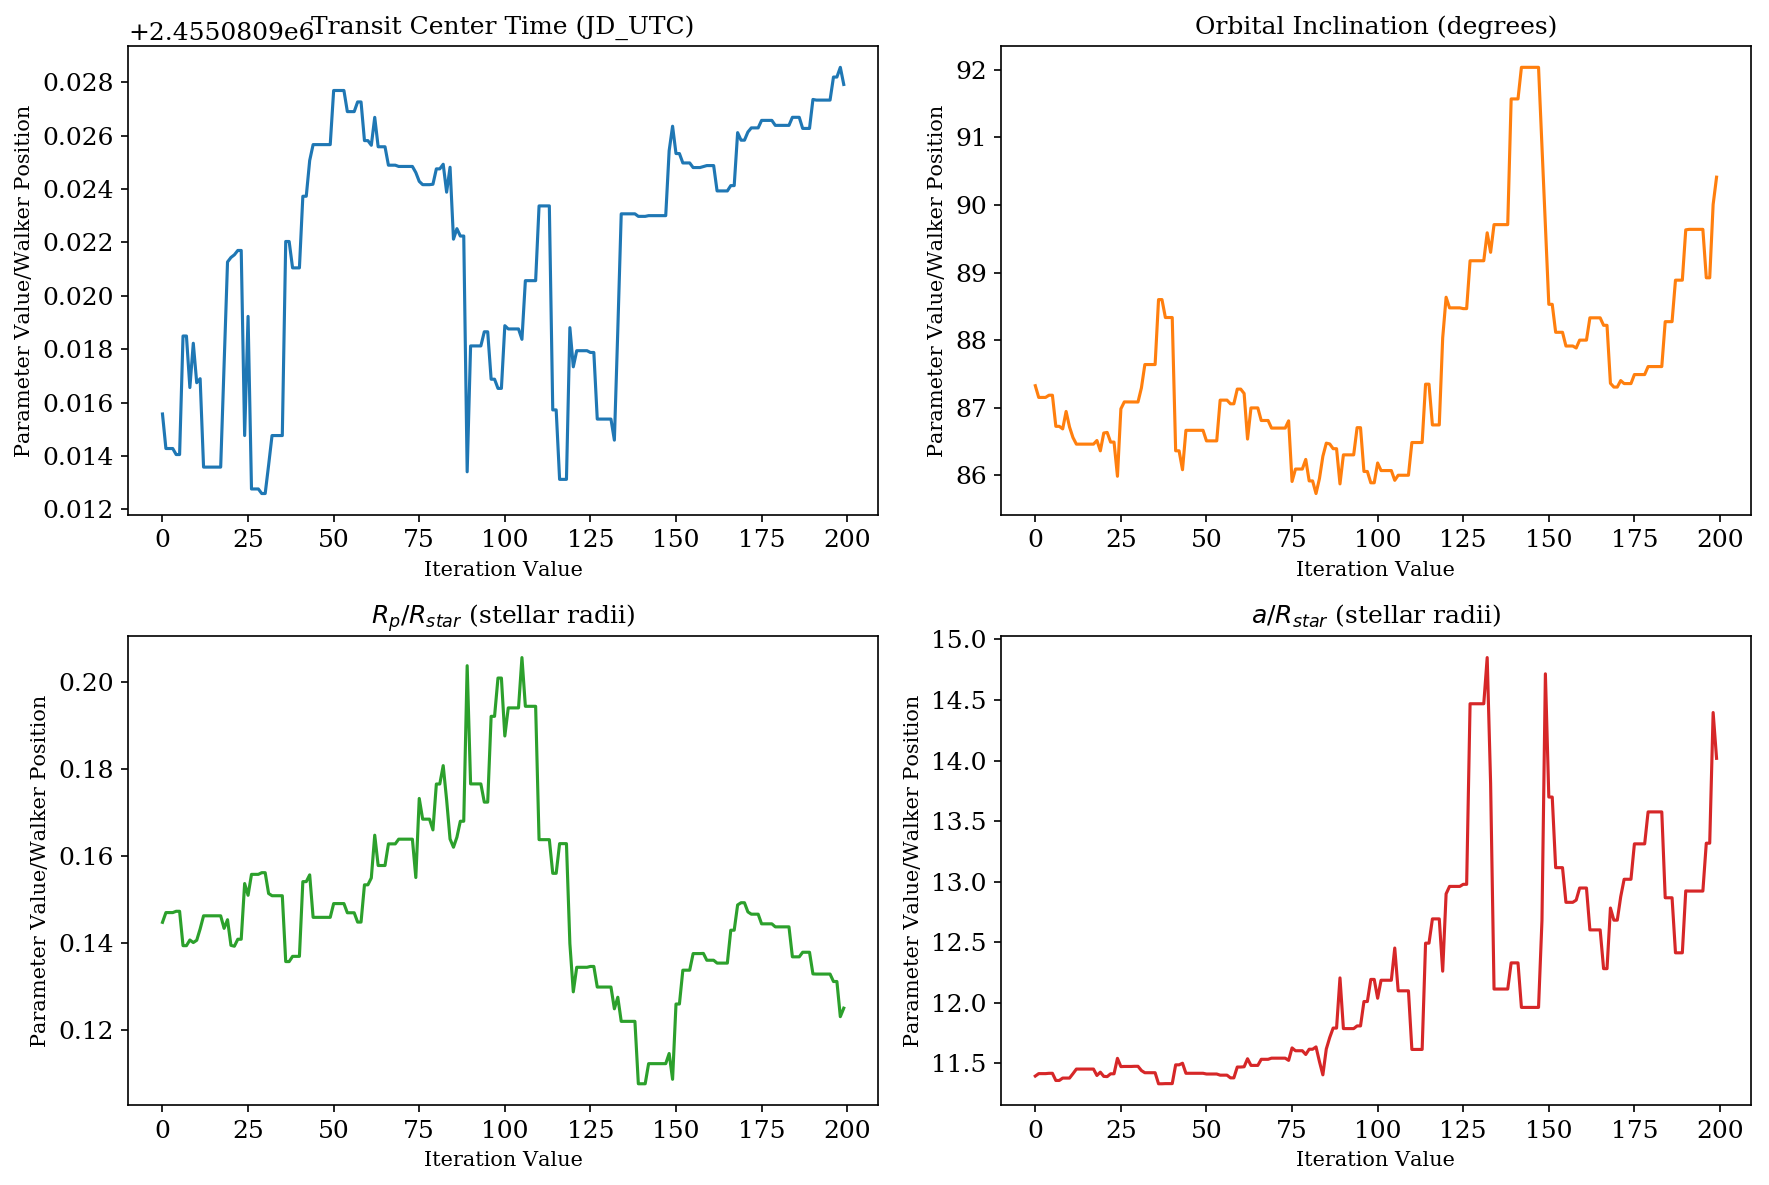

In [64]:
# 3D sampler.chain.shape plots - To Check Parameter Values for Each Walker (1-10)
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs[0, 0].plot(sampler.chain[1,:,0])
axs[0, 0].set_title('Transit Center Time (JD_UTC)')
axs[0, 1].plot(sampler.chain[1,:,1], 'tab:orange')
axs[0, 1].set_title('Orbital Inclination (degrees)')
axs[1, 0].plot(sampler.chain[1,:,2], 'tab:green')
axs[1, 0].set_title('$R_p/R_{star}$ (stellar radii)')
axs[1, 1].plot(sampler.chain[1,:,3], 'tab:red')
axs[1, 1].set_title('$a/R_{star}$ (stellar radii)')
for ax in axs.flat:
    ax.set(xlabel='Iteration Value', ylabel='Parameter Value/Walker Position')
fig.tight_layout()
fig.show()

## sampler.flatchain.shape

In [21]:
print(sampler.flatchain.shape)

(2000, 4)


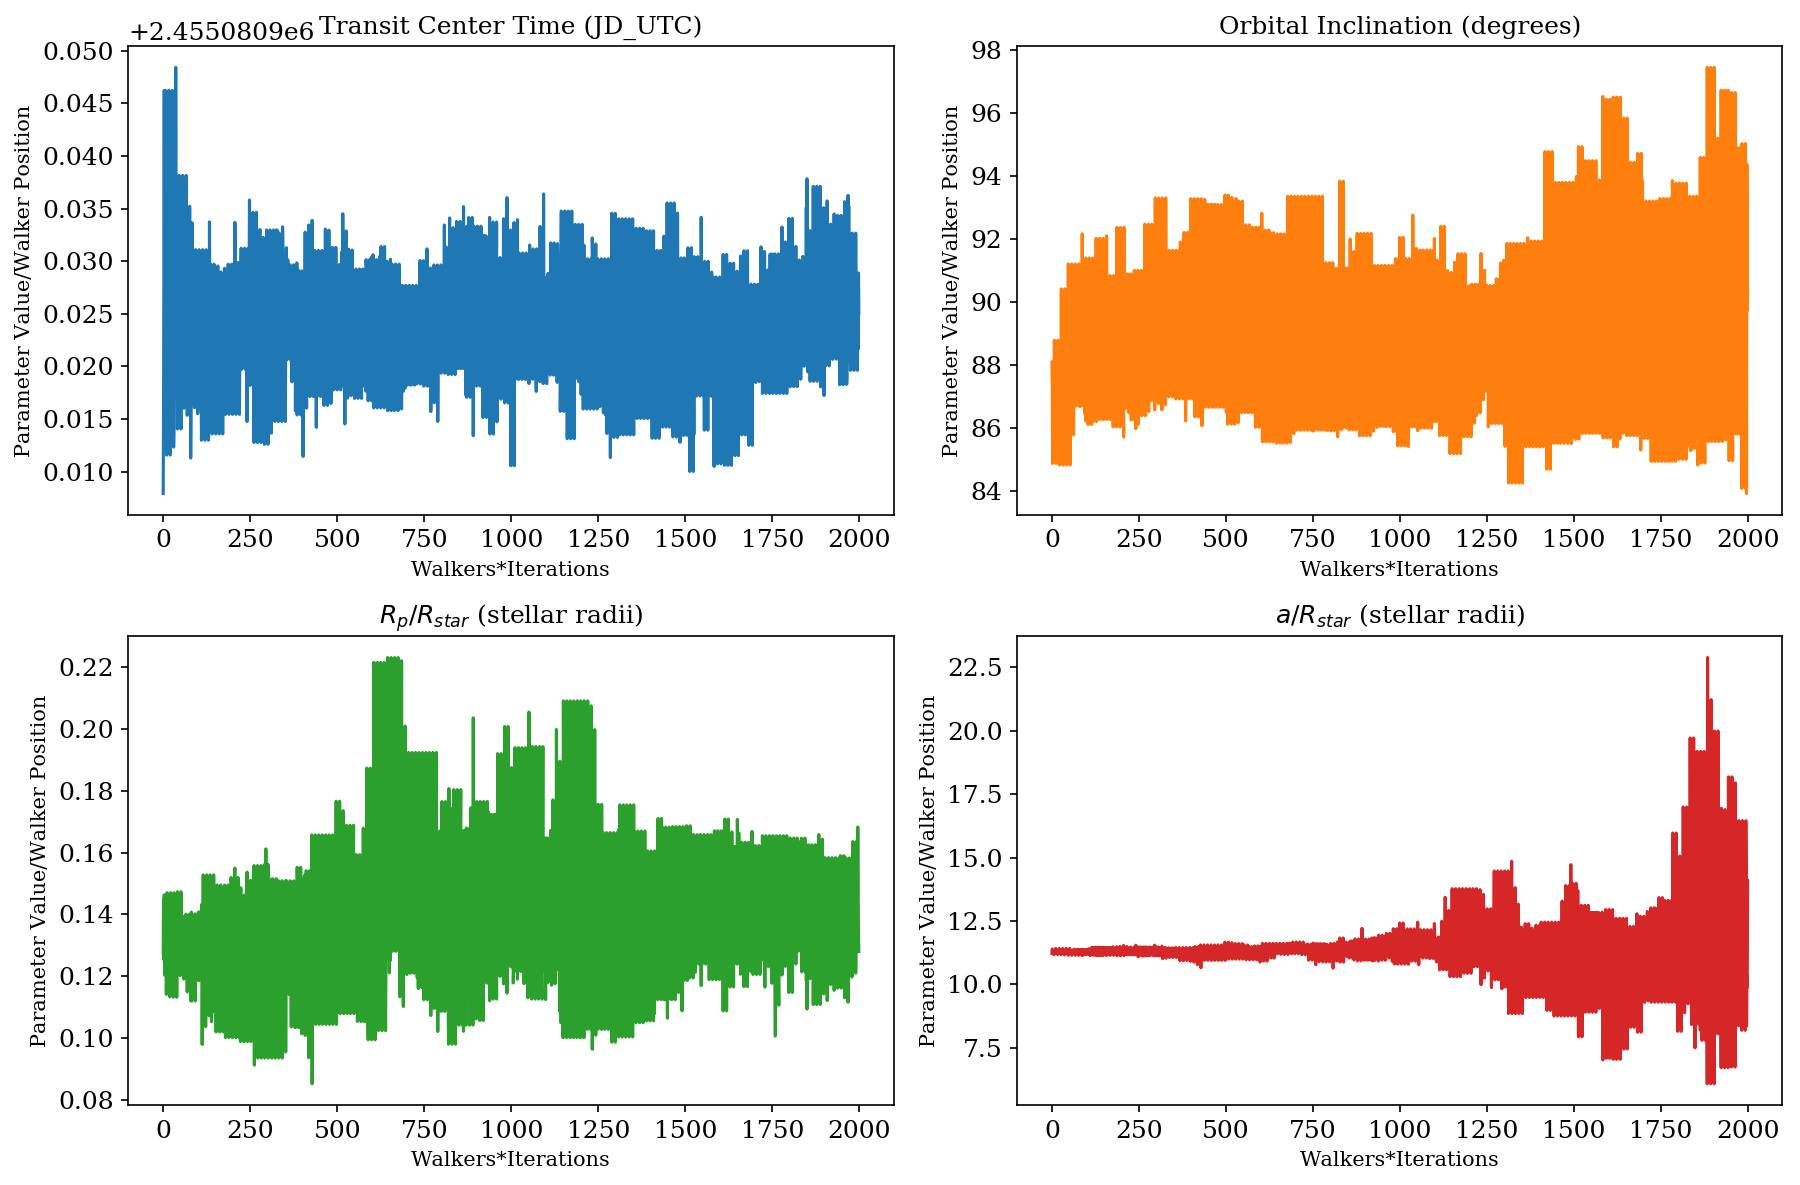

In [66]:
# 2D sampler.flatchain.shape plots - To Check Parameter Values for All Walkers (Walkers*Iterations)
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs[0, 0].plot(sampler.flatchain[:,0])
axs[0, 0].set_title('Transit Center Time (JD_UTC)')
axs[0, 1].plot(sampler.flatchain[:,1], 'tab:orange')
axs[0, 1].set_title('Orbital Inclination (degrees)')
axs[1, 0].plot(sampler.flatchain[:,2], 'tab:green')
axs[1, 0].set_title('$R_p/R_{star}$ (stellar radii)')
axs[1, 1].plot(sampler.flatchain[:,3], 'tab:red')
axs[1, 1].set_title('$a/R_{star}$ (stellar radii)')
for ax in axs.flat:
    ax.set(xlabel='Walkers*Iterations', ylabel='Parameter Value/Walker Position')
fig.tight_layout()
fig.show()

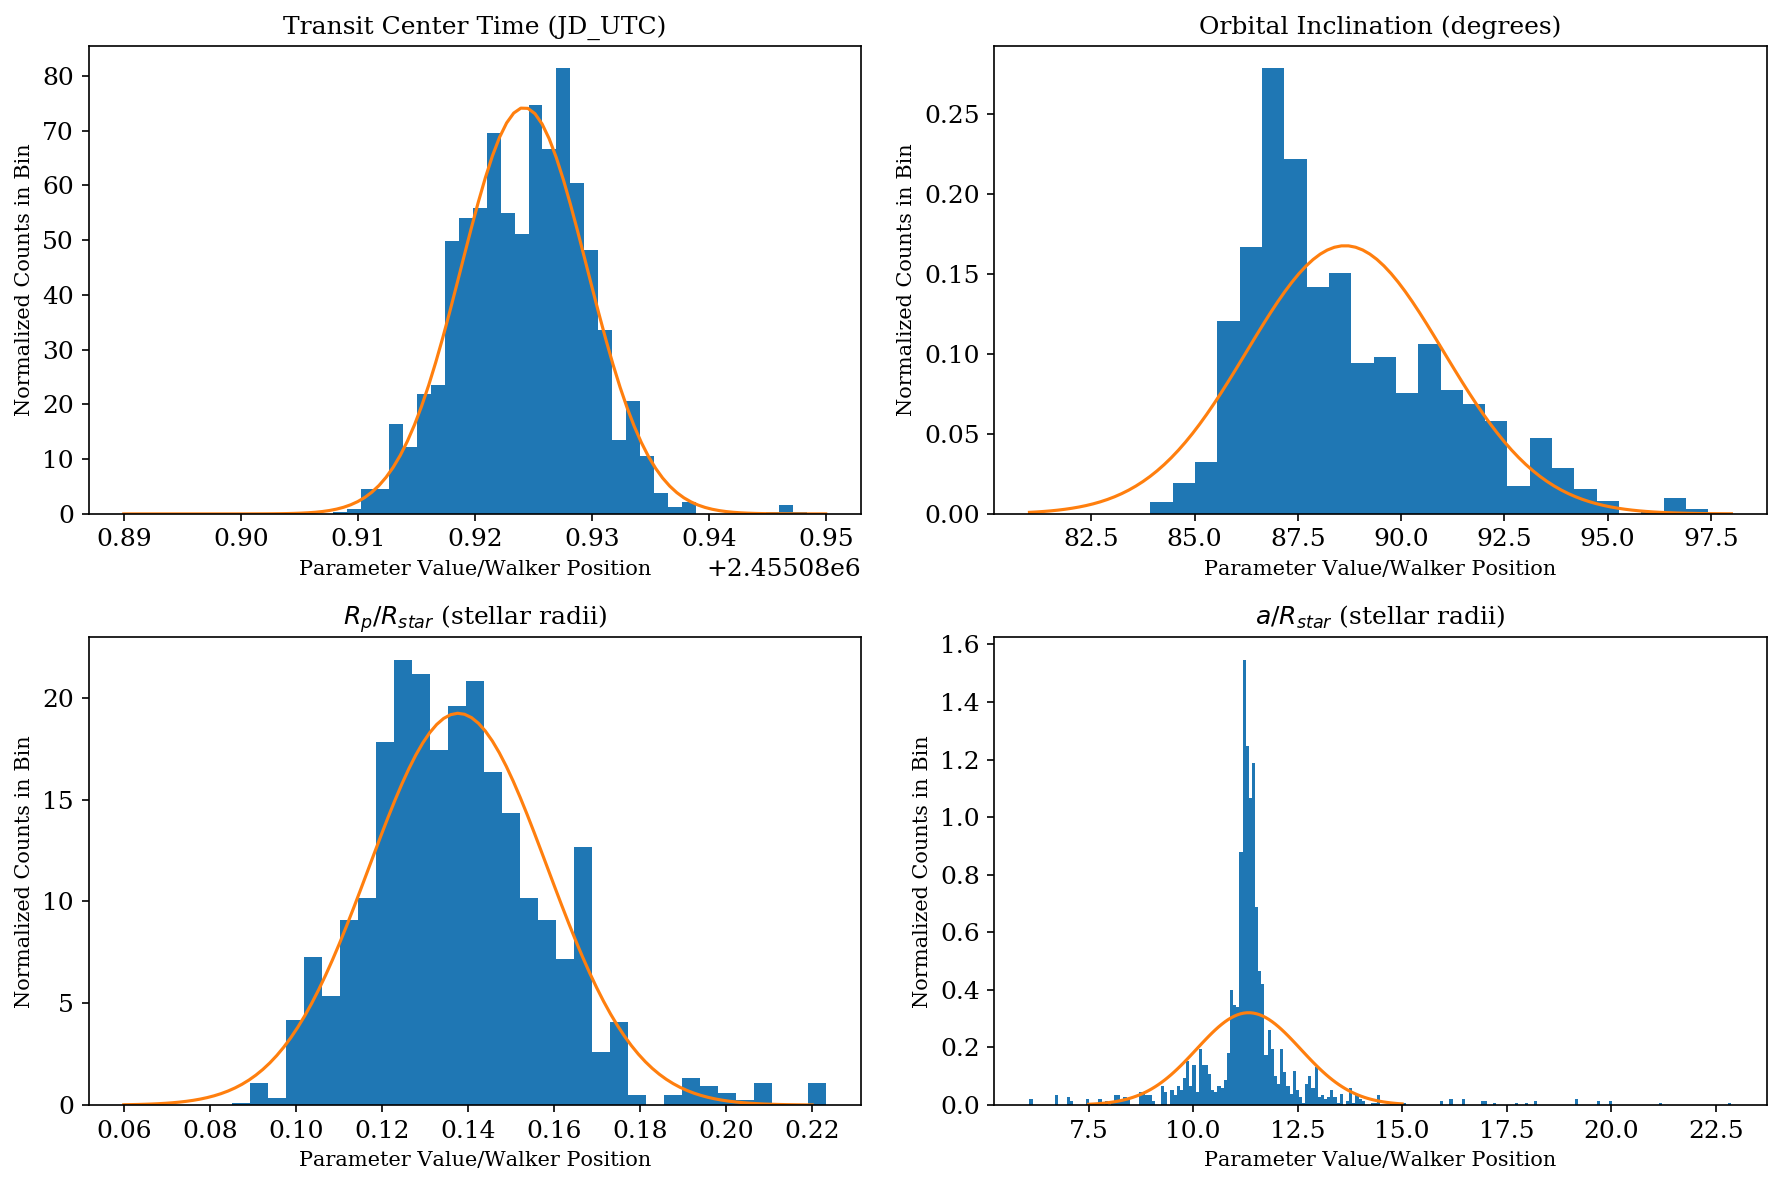

In [117]:
# 2D sampler.flatchain.shape Histograms - To Check Probability Distribution
fig, axs = plt.subplots(2, 2, figsize=(12,8))

mean,std = norm.fit(sampler.flatchain[:,0])
x0 = np.linspace(2455080.89, 2455080.95, 100)
y0 = norm.pdf(x0, mean, std)
axs[0, 0].hist(sampler.flatchain[:,0], bins='auto', density = True)
axs[0, 0].plot(x0,y0)
axs[0, 0].set_title('Transit Center Time (JD_UTC)')

mean1,std1 = norm.fit(sampler.flatchain[:,1])
x1 = np.linspace(81, 98, 100)
y1 = norm.pdf(x1, mean1, std1)
axs[0, 1].hist(sampler.flatchain[:,1], bins='auto', density = True)
axs[0, 1].plot(x1,y1)
axs[0, 1].set_title('Orbital Inclination (degrees)')

mean2,std2 = norm.fit(sampler.flatchain[:,2])
x2 = np.linspace(0.06, 0.22, 100)
y2 = norm.pdf(x2, mean2, std2)
axs[1, 0].hist(sampler.flatchain[:,2], bins='auto', density = True)
axs[1, 0].plot(x2,y2)
axs[1, 0].set_title('$R_p/R_{star}$ (stellar radii)')

mean3,std3 = norm.fit(sampler.flatchain[:,3])
x3 = np.linspace(7.5, 15, 100)
y3 = norm.pdf(x3, mean3, std3)
axs[1, 1].hist(sampler.flatchain[:,3], bins='auto', density = True)
axs[1, 1].plot(x3,y3)
axs[1, 1].set_title('$a/R_{star}$ (stellar radii)')
for ax in axs.flat:
    ax.set(xlabel='Parameter Value/Walker Position', ylabel='Normalized Counts in Bin')
fig.tight_layout()
fig.show()

In [28]:
medval = np.median(sampler.flatchain[:,2])
minus = medval - np.percentile(sampler.flatchain[:,2],16.0)
plus = np.percentile(sampler.flatchain[:,2],84.0)- medval
print(medval)
print(minus)
print(plus)

0.13623906624364604
0.017399277075543784
0.022021287564850334
